## Imports

In [62]:
import torch
import logging
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib.pyplot import savefig
import pandas as pd
from time import sleep
import json
logging.basicConfig(level=logging.INFO)# OPTIONAL
import numpy as np; np.random.seed(42)
import seaborn as sb 
from matplotlib.colors import LinearSegmentedColormap

## MAC Settings

In [63]:
print(f"PyTorch version: {torch.__version__}")
# Set the device      
device = "mps" if torch.backends.mps.is_available() else torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

PyTorch version: 1.13.1
Using device: mps


## Definitions

In [64]:
#TEMPLATES
EVALUATION_PATH = '../data/evaluation/'
RESULTS_PATH = '../data/results/'
ALBERT_BASE_TEMPLATE_1 = 'ALBERTbase[1]'
ALBERT_BASE_TEMPLATE_5 = 'ALBERTbase[5]'
ALBERT_LARGE_TEMPLATE_1 = 'ALBERTlarge[1]'
ALBERT_LARGE_TEMPLATE_5 = 'ALBERTlarge[5]'
BERT_BASE_TEMPLATE_1 = 'BERTbase[1]'
BERT_BASE_TEMPLATE_5 = 'BERTbase[5]'
BERT_LARGE_TEMPLATE_1 = 'BERTlarge[1]'
BERT_LARGE_TEMPLATE_5 = 'BERTlarge[5]'
ROBERTA_BASE_TEMPLATE_1 = 'RoBERTabase[1]'
ROBERTA_BASE_TEMPLATE_5 = 'RoBERTabase[5]'
ROBERTA_LARGE_TEMPLATE_1 = 'RoBERTalarge[1]'
ROBERTA_LARGE_TEMPLATE_5 = 'RoBERTalarge[5]'
BERTWEET_BASE_TEMPLATE_1 = 'BERTweetbase[1]'
BERTWEET_BASE_TEMPLATE_5 = 'BERTweetbase[5]'
BERTWEET_LARGE_TEMPLATE_1 = 'BERTweetlarge[1]'
BERTWEET_LARGE_TEMPLATE_5 = 'BERTweetlarge[5]'

MODELS =[ALBERT_BASE_TEMPLATE_1, ALBERT_LARGE_TEMPLATE_1, ALBERT_BASE_TEMPLATE_5, ALBERT_LARGE_TEMPLATE_5, 
         BERT_BASE_TEMPLATE_1, BERT_LARGE_TEMPLATE_1, BERT_BASE_TEMPLATE_5, BERT_LARGE_TEMPLATE_5,
         ROBERTA_BASE_TEMPLATE_1, ROBERTA_LARGE_TEMPLATE_1, ROBERTA_BASE_TEMPLATE_5, ROBERTA_LARGE_TEMPLATE_5,
         BERTWEET_BASE_TEMPLATE_1, BERTWEET_LARGE_TEMPLATE_1, BERTWEET_BASE_TEMPLATE_5, BERTWEET_LARGE_TEMPLATE_5]
ALBERT_MODELS = [ALBERT_BASE_TEMPLATE_1, ALBERT_LARGE_TEMPLATE_1, ALBERT_BASE_TEMPLATE_5, ALBERT_LARGE_TEMPLATE_5]
BERT_MODELS = [BERT_BASE_TEMPLATE_1, BERT_LARGE_TEMPLATE_1, BERT_BASE_TEMPLATE_5, BERT_LARGE_TEMPLATE_5]
ROBERTA_MODELS= [ROBERTA_BASE_TEMPLATE_1, ROBERTA_LARGE_TEMPLATE_1, ROBERTA_BASE_TEMPLATE_5, ROBERTA_LARGE_TEMPLATE_5]
BERTWEET_MODELS= [BERTWEET_BASE_TEMPLATE_1, BERTWEET_LARGE_TEMPLATE_1, BERTWEET_BASE_TEMPLATE_5, BERTWEET_LARGE_TEMPLATE_5]
MODELS_NAMES = ['ALBERTbase[1]','ALBERTbase[5]','ALBERTlarge[1]','ALBERTlarge[5]',
                'BERTbase[1]','BERTbase[5]','BERTlarge[1]','BERTlarge[5]', 
                'RoBERTabase[1]','RoBERTabase[5]','RoBERTalarge[1]','RoBERTalarge[5]',
                'BERTweetbase[1]','BERTweetbase[5]','BERTweetlarge[1]','BERTweetlarge[5]']

NEO_ROW = 0
NEUTRAL_ROW = 1
BINARY_ROW = 2
QUEER_IDENTITY = 3
QUEER_ORIENTATION = 4
QUEER_OTHER = 5
NON_QUEER_IDENTITY = 6
NON_QUEER_ORIENTATION = 7
NON_QUEER_OTHER = 8
QUEER_ROW = 9
NON_QUEER_ROW = 10 

#KEY
PRONOUN = 'pronoun'
TERM = 'term'
NEO = 'Neo'
NEUTRAL = 'Neutral'
BINARY = 'Binary'
QUEER = 'Queer'
NON_QUEER = 'Non Queer'
SCORE = 'Score'
TOT = 'Tot'
STDEV =  'StDev'

perspective_cat = ['Toxicity', 'Identity attack', 'Insult', 'Profanity', 'Threat']
hurtlex_cat = ['Animals', 'Crime and immoral behavior', 'Derogatory words', 'Female genitalia', 'Male genitalia', 'Homosexuality', 'Potential negative connotations', 'Professions and occupations', 'Prostitution', 'Social and economic disadvantage']
hurtlex_cat_names = ['AN', 'RE', 'CDS', 'ASF', 'ASM', 'OM', 'QAS', 'PA', 'PR', 'IS']
IBM_colorBlindPalette = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000"]
PaulTol_colorBlindPalette = ["#332288", "#88ccee", "#44aa99", "#117733", "#999933", "#ddcc77", "#cc6677", "#882255", "#aa4499", "#dddddd"]
heatmap_colorBlindPalette = ["#e4ff7a", "#ffe81a", "#ffbd00", "#ffa000", "#fc7f00"]
FONT_SIZE_BIG = 14
FONT_SIZE = 11
NCOL = 2

In [65]:
def truncate_float(float_number, decimal_places = 2):
    multiplier = 10 ** decimal_places
    return int(float_number * multiplier) / multiplier

# Graph

In [66]:
def afinn_graph(models, type):
    x = []
    fig, ax = plt.subplots()
    plt.ylabel("Average score", fontsize=FONT_SIZE_BIG)
    plt.xlabel("Model", fontsize=FONT_SIZE_BIG)
    if models == MODELS:
        plt.xticks(rotation=30, rotation_mode="anchor", fontsize = FONT_SIZE)
    else:
        plt.xticks(rotation=20, rotation_mode="anchor", fontsize = FONT_SIZE)
    plt.yticks(fontsize = FONT_SIZE)
    plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
   
    if type == PRONOUN:
        y1_neo, y2_neutral, y3_binary= [], [], []
        yerr1_neo, yerr2_neutral, yerr3_binary = [], [], []
        df_neo, df_neutral, df_binary = [], [], []
        for m in models:
            csv = pd.read_csv(RESULTS_PATH+m+'_afinn.csv', sep=";")
            x.append(m)
            y1_neo.append(csv.loc[NEO_ROW][SCORE])
            y2_neutral.append(csv.loc[NEUTRAL_ROW][SCORE])
            y3_binary.append(csv.loc[BINARY_ROW][SCORE])
            yerr1_neo.append(csv.loc[NEO_ROW][STDEV])
            yerr2_neutral.append(csv.loc[NEUTRAL_ROW][STDEV])
            yerr3_binary.append(csv.loc[BINARY_ROW][STDEV])
            df_neo.append(f"\({csv.loc[NEO_ROW][SCORE]:.2f} \pm { csv.loc[NEO_ROW][STDEV]:.2f}\)")
            df_neutral.append(f"\({csv.loc[NEUTRAL_ROW][SCORE]:.2f} \pm {csv.loc[NEUTRAL_ROW][STDEV]:.2f}\)")
            df_binary.append(f"\({csv.loc[BINARY_ROW][SCORE]:.2f} \pm {csv.loc[BINARY_ROW][STDEV]:.2f}\)")
        
        trans1 = Affine2D().translate(0.0, 0.0) + ax.transData
        trans2 = Affine2D().translate(+0.1, 0.0) + ax.transData
        trans3 = Affine2D().translate(+0.2, 0.0) + ax.transData
        er1 = ax.errorbar(x, y1_neo, yerr=yerr1_neo, linestyle = ':', capsize=3, marker="o", transform=trans1)
        er2 = ax.errorbar(x, y2_neutral, yerr=yerr2_neutral, linestyle = ':', capsize=3, marker="o", transform=trans2)
        er3 = ax.errorbar(x, y3_binary, yerr=yerr3_binary, linestyle = ':', capsize=3, marker="o", transform=trans3)
        ax.legend([NEO, NEUTRAL, BINARY], ncol = NCOL)
       
        df = pd.DataFrame(columns=models, index = ['Neo', 'Neutral', 'Binary'])
        df.loc['Neo'] = df_neo 
        df.loc['Neutral'] = df_neutral
        df.loc['Binary'] = df_binary
        #display(df) 
    else:
        y1_queer, y2_non= [], []
        yerr1_queer, yerr2_non= [], []
        df_queer, df_non = [], []
        for m in models:
            csv = pd.read_csv(RESULTS_PATH+m+'_afinn.csv', sep=";")
            x.append(m)
            y1_queer.append(csv.loc[QUEER_ROW][SCORE])
            y2_non.append(csv.loc[NON_QUEER_ROW][SCORE])
            yerr1_queer.append(csv.loc[QUEER_ROW][STDEV])
            yerr2_non.append(csv.loc[NON_QUEER_ROW][STDEV])
            df_queer.append(f"\({csv.loc[QUEER_ROW][SCORE]:.2f} \pm { csv.loc[QUEER_ROW][STDEV]:.2f}\)")
            df_non.append(f"\({csv.loc[NON_QUEER_ROW][SCORE]:.2f} \pm {csv.loc[NON_QUEER_ROW][STDEV]:.2f}\)")
        
        trans1 = Affine2D().translate(0.0, 0.0) + ax.transData
        trans2 = Affine2D().translate(+0.1, 0.0) + ax.transData
        er1 = ax.errorbar(x, y1_queer, yerr=yerr1_queer, linestyle = ':', capsize=3, marker="o", transform=trans1)
        er2 = ax.errorbar(x, y2_non, yerr=yerr2_non, linestyle = ':', capsize=3, marker="o", transform=trans2)
        ax.legend([QUEER, NON_QUEER], ncol = NCOL)

        df = pd.DataFrame(columns=models, index = ['Queer', 'Non Queer'])
        df.loc['Queer'] = df_queer 
        df.loc['Non Queer'] = df_non
        #display(df) 

    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.tight_layout()
    if models == MODELS:
        plt.savefig('../graphs/pronoun/'+ 'afinn_all.png', transparent=True)
    else: 
        plt.savefig('../graphs/'+type+'/afinn_'+ (models[0].replace("base[1]", "")) +'.png', transparent=True)
    plt.show()
#afinn_graph(ALBERT_MODELS, TERM)

In [67]:
def perspective_graph(models, type):
    fig, ax1 = plt.subplots()
    plt.setp(ax1.xaxis.get_majorticklabels(), ha='right')
    ax1.set_xlabel('Model', fontsize = FONT_SIZE_BIG)
    ax1.set_ylabel('Perspective score %', fontsize = FONT_SIZE_BIG)
    if models == MODELS:
        plt.xticks(rotation=30, rotation_mode="anchor", fontsize = FONT_SIZE)
    else:
        plt.xticks(rotation=20, rotation_mode="anchor", fontsize = FONT_SIZE)
    plt.yticks(fontsize = FONT_SIZE)
    plt.grid(linestyle = '--', linewidth = 0.5)

    if type == TERM:
        bar_width = 0.40
        x_labels, bar_data1, bar_data2, line_data1, line_data2 = [], [], [], [], []
        tox_queer, id_queer, ins_queer, prof_queer, thre_queer, tox_non, id_non, ins_non, prof_non, thre_non = [], [], [], [], [], [], [], [], [], []
        data1 = [tox_queer, id_queer, ins_queer, prof_queer, thre_queer]
        data2 = [tox_non, id_non, ins_non, prof_non, thre_non]
        for m in models:
            csv = pd.read_csv(RESULTS_PATH+m+'_perspective.csv', sep=";", index_col=[0])
            x_labels.append(m)
            for ind, d in enumerate(data1):
                d.append((csv.loc[QUEER][perspective_cat[ind]]/csv.loc[QUEER][TOT])*100)
            for ind, d in enumerate(data2):
                d.append((csv.loc[NON_QUEER][perspective_cat[ind]]/csv.loc[NON_QUEER][TOT])*100)

            line_data1.append(csv.loc[QUEER][SCORE])
            line_data2.append(csv.loc[NON_QUEER][SCORE])

        for d in data1:
            bar_data1.append(d)
        for d in data2:
            bar_data2.append(d)
        
        x = np.arange(len(x_labels))

        # Create the set of bars
        bottom1 = np.zeros(len(x_labels))
        for i, data in enumerate(bar_data1):
            ax1.bar(x - bar_width/2, data, width=bar_width, label=f'{perspective_cat[i]}', color= PaulTol_colorBlindPalette[i], bottom=bottom1,  edgecolor = "white", linewidth = 0.5)
            bottom1 += data

        bottom2 = np.zeros(len(x_labels))
        for i, data in enumerate(bar_data2):
            ax1.bar(x + bar_width/2, data, width=bar_width, color= PaulTol_colorBlindPalette[i], bottom=bottom2,  edgecolor = "white", linewidth = 0.5)
            bottom2 += data

        ax1.plot(x - bar_width/2, line_data1, linestyle = 'None', marker = "o",  markersize=5, label=QUEER)
        ax1.plot(x + bar_width/2, line_data2, linestyle = 'None', marker = "^",  markersize=5, label=NON_QUEER)
    else:
        bar_width = 0.75
        x_labels, bar_data1, bar_data2, bar_data3, line_data1, line_data2, line_data3 = [], [], [], [], [], [], []
        tox_neo, id_neo, ins_neo, prof_neo, thre_neo, tox_neu, id_neu, ins_neu, prof_neu, thre_neu, tox_bin, id_bin, ins_bin, prof_bin, thre_bin = [], [], [], [], [], [], [], [], [], [],[], [], [], [], []
        data1 = [tox_neo, id_neo, ins_neo, prof_neo, thre_neo]
        data2 = [tox_neu, id_neu, ins_neu, prof_neu, thre_neu]
        data3 = [tox_bin, id_bin, ins_bin, prof_bin, thre_bin]
        for m in models:
            csv = pd.read_csv(RESULTS_PATH+m+'_perspective.csv', sep=";", index_col=[0])
            x_labels.append(m)

            for ind, d in enumerate(data1):
                d.append((csv.loc[NEO][perspective_cat[ind]]/csv.loc[NEO][TOT])*100)
            for ind, d in enumerate(data2):
                d.append((csv.loc[NEUTRAL][perspective_cat[ind]]/csv.loc[NEUTRAL][TOT])*100)
            for ind, d in enumerate(data3):
                d.append((csv.loc[BINARY][perspective_cat[ind]]/csv.loc[BINARY][TOT])*100)
                
            line_data1.append(csv.loc[NEO][SCORE])
            line_data2.append(csv.loc[NEUTRAL][SCORE])
            line_data3.append(csv.loc[BINARY][SCORE])

        for d in data1:
            bar_data1.append(d)
        for d in data2:
            bar_data2.append(d)
        for d in data3:
            bar_data3.append(d)
        
        # Create an array of x values for the bars
        x = np.arange(len(x_labels))
        
        # Create the first set of bars
        bottom1 = np.zeros(len(x_labels))
        for i, data in enumerate(bar_data1):
            ax1.bar(x - bar_width/3, data, width=bar_width/3, label=f'{perspective_cat[i]}', color= PaulTol_colorBlindPalette[i], bottom=bottom1,  edgecolor = "white", linewidth = 0.5)
            bottom1 += data

        bottom2 = np.zeros(len(x_labels))
        for i, data in enumerate(bar_data2):
            ax1.bar(x, data, width=bar_width/3, color= PaulTol_colorBlindPalette[i], bottom=bottom2, edgecolor = "white", linewidth = 0.5)
            bottom2 += data

        bottom3 = np.zeros(len(x_labels))
        for i, data in enumerate(bar_data3):
            ax1.bar(x + bar_width/3, data, width=bar_width/3, color= PaulTol_colorBlindPalette[i], bottom=bottom3, edgecolor = "white", linewidth = 0.5)
            bottom3 += data

        # Create the first set of line plots
        ax1.plot(x - bar_width/3, line_data1, linestyle = 'None', marker = "o",  markersize=5, label=NEO)
        ax1.plot(x , line_data2, linestyle = 'None', marker = "^",  markersize=5, label=NEUTRAL)
        ax1.plot(x + bar_width/3, line_data3, linestyle = 'None', marker = "s",  markersize=5, label=BINARY)

    ax1.set_xticks(x)
    ax1.set_xticklabels(x_labels)
    ax1.legend(ncol = NCOL)
    plt.tight_layout()
    if models == MODELS:
        plt.savefig('../graphs/pronoun/'+ 'perspective_all.png', transparent=True)
    else: 
        plt.savefig('../graphs/'+type+'/perspective_'+ (models[0].replace("base[1]", "")) +'.png', transparent=True)
    plt.show()
    plt.close()

#perspective_graph(BERT_MODELS, TERM)


In [68]:
def hurtlex_graph(models, type):
    fig, ax1 = plt.subplots()
    plt.setp(ax1.xaxis.get_majorticklabels(), ha='right')
    ax1.set_xlabel('Model', fontsize = FONT_SIZE_BIG)
    ax1.set_ylabel('Hurtlex score %', fontsize = FONT_SIZE_BIG)
    if models == MODELS:
        plt.xticks(rotation=30, rotation_mode="anchor", fontsize = FONT_SIZE)
    else:
        plt.xticks(rotation=20, rotation_mode="anchor", fontsize = FONT_SIZE)
    plt.yticks(fontsize = FONT_SIZE)
    plt.grid(linestyle = '--', linewidth = 0.5)

    if type == TERM:
        bar_width = 0.40
        x_labels, bar_data1, bar_data2, line_data1, line_data2 = [], [], [], [], []
        an_queer, re_queer, cds_queer, asf_queer, asm_queer, om_queer, qas_queer, pa_queer, pr_queer, is_queer = [], [], [], [], [], [], [], [], [], []
        an_non, re_non, cds_non, asf_non, asm_non, om_non, qas_non, pa_non, pr_non, is_non = [], [], [], [], [], [], [], [], [], []
        data1 = [an_queer, re_queer, cds_queer, asf_queer, asm_queer, om_queer, qas_queer, pa_queer, pr_queer, is_queer]
        data2 = [an_non, re_non, cds_non, asf_non, asm_non, om_non, qas_non, pa_non, pr_non, is_non]
        for m in models:
            csv = pd.read_csv(RESULTS_PATH+m+'_hurtlex.csv', sep=";", index_col=[0])
            x_labels.append(m)
            for ind, d in enumerate(data1):
                d.append((csv.loc[QUEER][hurtlex_cat[ind]]/csv.loc[QUEER][TOT])*100)
            for ind, d in enumerate(data2):
                d.append((csv.loc[NON_QUEER][hurtlex_cat[ind]]/csv.loc[NON_QUEER][TOT])*100)

            line_data1.append(csv.loc[QUEER][SCORE])
            line_data2.append(csv.loc[NON_QUEER][SCORE])

        for d in data1:
            bar_data1.append(d)
        for d in data2:
            bar_data2.append(d)
        
        x = np.arange(len(x_labels))
        
        # Create the first set of bars
        bottom1 = np.zeros(len(x_labels))
        for i, data in enumerate(bar_data1):
            ax1.bar(x - bar_width/2, data, width=bar_width, label=f'{hurtlex_cat_names[i]}',  color= PaulTol_colorBlindPalette[i], bottom=bottom1, edgecolor = "white", linewidth = 0.5)
            bottom1 += data

        bottom2 = np.zeros(len(x_labels))
        for i, data in enumerate(bar_data2):
            ax1.bar(x + bar_width/2, data, width=bar_width, color= PaulTol_colorBlindPalette[i], bottom=bottom2, edgecolor = "white", linewidth = 0.5)
            bottom2 += data

        # Create the first set of line plots
        ax1.plot(x - bar_width/2, line_data1, linestyle = 'None', marker = "o",  markersize=5, label=QUEER)
        ax1.plot(x + bar_width/2, line_data2, linestyle = 'None', marker = "^",  markersize=5, label=NON_QUEER)
    else:
        bar_width = 0.75
        x_labels, bar_data1, bar_data2, bar_data3, line_data1, line_data2, line_data3 = [], [], [], [], [], [], []
        an_neo, re_neo, cds_neo, asf_neo, asm_neo, om_neo, qas_neo, pa_neo, pr_neo, is_neo = [], [], [], [], [], [], [], [], [], []
        an_neu, re_neu, cds_neu, asf_neu, asm_neu, om_neu, qas_neu, pa_neu, pr_neu, is_neu = [], [], [], [], [], [], [], [], [], []
        an_bin, re_bin, cds_bin, asf_bin, asm_bin, om_bin, qas_bin, pa_bin, pr_bin, is_bin = [], [], [], [], [], [], [], [], [], []
        data1 = [an_neo, re_neo, cds_neo, asf_neo, asm_neo, om_neo, qas_neo, pa_neo, pr_neo, is_neo]
        data2 = [an_neu, re_neu, cds_neu, asf_neu, asm_neu, om_neu, qas_neu, pa_neu, pr_neu, is_neu]
        data3 = [an_bin, re_bin, cds_bin, asf_bin, asm_bin, om_bin, qas_bin, pa_bin, pr_bin, is_bin]
        for m in models:
            csv = pd.read_csv(RESULTS_PATH+m+'_hurtlex.csv', sep=";", index_col=[0])
            x_labels.append(m)
            for ind, d in enumerate(data1):
                d.append((csv.loc[NEO][hurtlex_cat[ind]]/csv.loc[NEO][TOT])*100)
            for ind, d in enumerate(data2):
                d.append((csv.loc[NEUTRAL][hurtlex_cat[ind]]/csv.loc[NEUTRAL][TOT])*100)
            for ind, d in enumerate(data3):
                d.append((csv.loc[BINARY][hurtlex_cat[ind]]/csv.loc[BINARY][TOT])*100)

            line_data1.append(csv.loc[NEO][SCORE])
            line_data2.append(csv.loc[NEUTRAL][SCORE])
            line_data3.append(csv.loc[BINARY][SCORE])

        for d in data1:
            bar_data1.append(d)
        for d in data2:
            bar_data2.append(d)
        for d in data3:
            bar_data3.append(d)

        x = np.arange(len(x_labels))
        
        # Create the first set of bars
        bottom1 = np.zeros(len(x_labels))
        for i, data in enumerate(bar_data1):
            ax1.bar(x - bar_width/3, data, width=bar_width/3, label=f'{hurtlex_cat_names[i]}',  color= PaulTol_colorBlindPalette[i], bottom=bottom1, edgecolor = "white", linewidth = 0.5)
            bottom1 += data

        bottom2 = np.zeros(len(x_labels))
        for i, data in enumerate(bar_data2):
            ax1.bar(x, data, width=bar_width/3, color= PaulTol_colorBlindPalette[i], bottom=bottom2, edgecolor = "white", linewidth = 0.5)
            bottom2 += data

        bottom3 = np.zeros(len(x_labels))
        for i, data in enumerate(bar_data3):
            ax1.bar(x + bar_width/3, data, width=bar_width/3, color= PaulTol_colorBlindPalette[i], bottom=bottom3,  edgecolor = "white", linewidth = 0.5)
            bottom3 += data
        
        # Create the first set of line plots
        ax1.plot(x - bar_width/3, line_data1, linestyle = 'None', marker = "o",  markersize=5, label=NEO)
        ax1.plot(x , line_data2, linestyle = 'None', marker = "^",  markersize=5, label=NEUTRAL)
        ax1.plot(x + bar_width/3, line_data3, linestyle = 'None', marker = "s",  markersize=5, label=BINARY)

    
    ax1.set_xticks(x)
    ax1.set_xticklabels(x_labels)
    ax1.legend(ncol = NCOL)
    plt.tight_layout()
    if models == MODELS:
        plt.savefig('../graphs/pronoun/'+ 'hurtlex_all.png', transparent=True)
    else: 
        plt.savefig('../graphs/'+type+'/hurtlex_'+ (models[0].replace("base[1]", "")) +'.png', transparent=True)
    plt.show()
    plt.close()
#hurtlex_graph(BERT_MODELS, PRONOUN)


In [69]:
def partial_graph(type, test):
    if type == PRONOUN:
        data = pd.read_csv(RESULTS_PATH+'total_score_pronouns.csv', sep=";", index_col=[0]) 
        data = (data[:9] if test == True else data[9:])
    else:
        data = pd.read_csv(RESULTS_PATH+'total_score_term.csv', sep=";", index_col=[0]) 
        data = (data[:6] if test == True else data[6:])
    
    fig, xaxis = plt.subplots(figsize=(10, 6))
    dataplot = sb.heatmap(data, cmap=heatmap_colorBlindPalette, annot=True, linewidths=1) 
    plt.xticks(rotation=45, rotation_mode="anchor", fontsize = FONT_SIZE)
    plt.yticks(rotation=45, rotation_mode="anchor", fontsize = FONT_SIZE)
    plt.title("QueerBench score on "+("pronouns" if type == PRONOUN else "nouns"), fontsize = FONT_SIZE_BIG)
    plt.setp(dataplot.xaxis.get_majorticklabels(), ha='right')
    plt.setp(dataplot.yaxis.get_majorticklabels(), ha='right')
    plt.tight_layout()
    plt.savefig('../graphs/'+type+ ('_test' if test is True else '_class')+ '.png', transparent=True)
    plt.show() 
    plt.close()
#partial_graph(TERM, True)

In [70]:
def total_table():

    data_pronoun = pd.read_csv(RESULTS_PATH+'total_score_pronouns.csv', sep=";", index_col=[0]) 
    data_pronoun =  data_pronoun[9:]
    #print(data_pronoun)
    
    data_term = pd.read_csv(RESULTS_PATH+'total_score_term.csv', sep=";", index_col=[0]) 
    data_term = data_term[6:]
    #print(data_term)

    data_total = pd.concat([data_pronoun, data_term])
    data_total = data_total.T
    display(data_total)

#total_table()

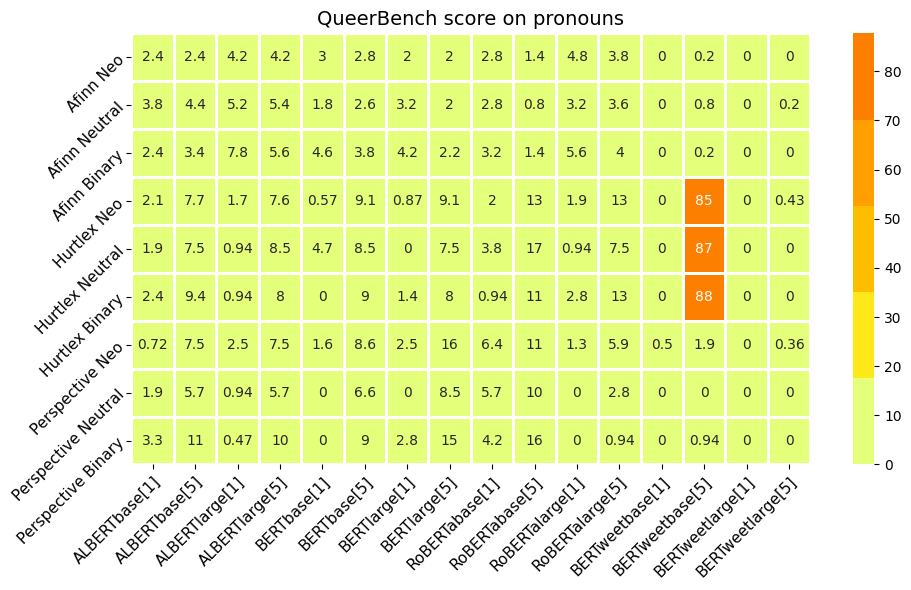

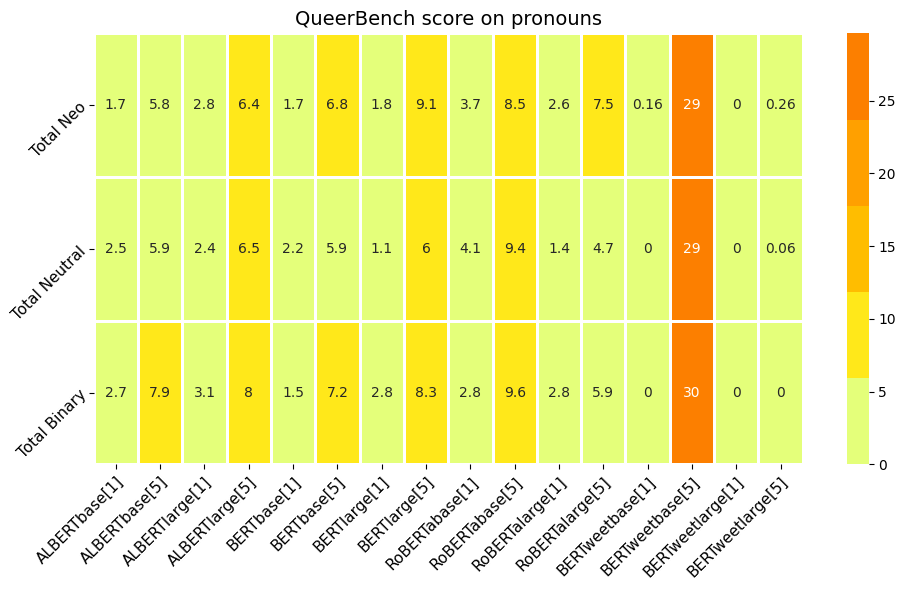

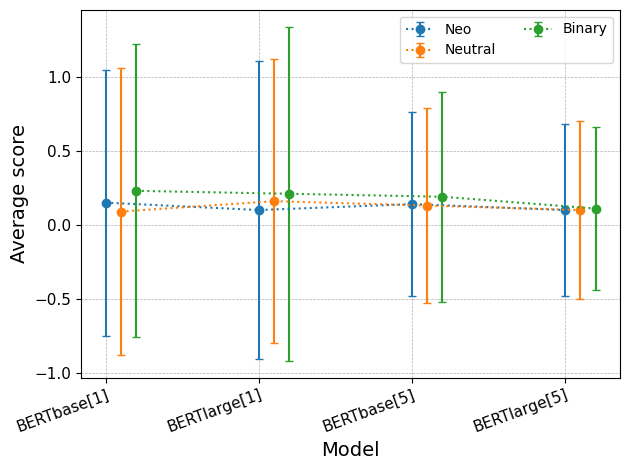

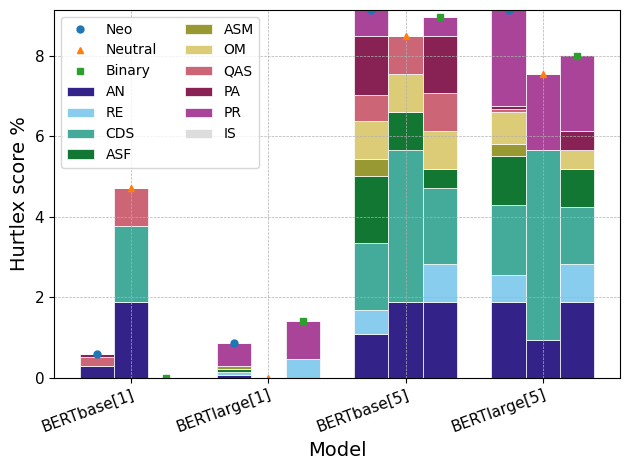

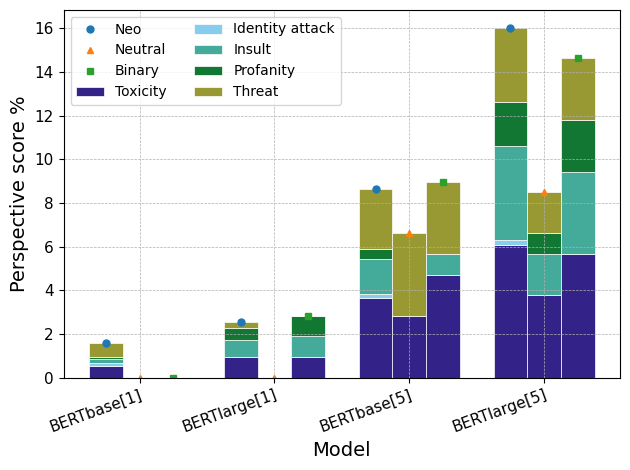

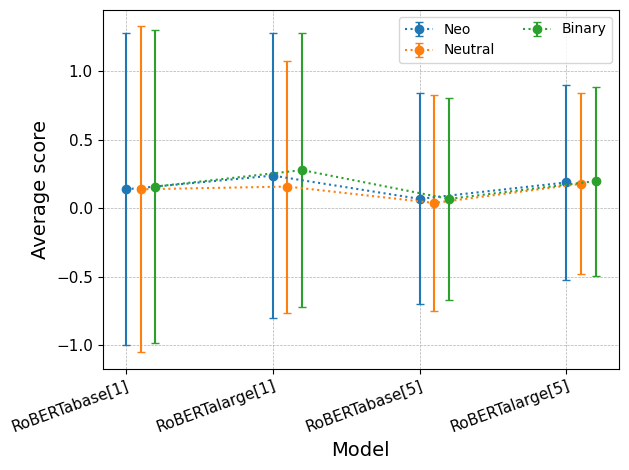

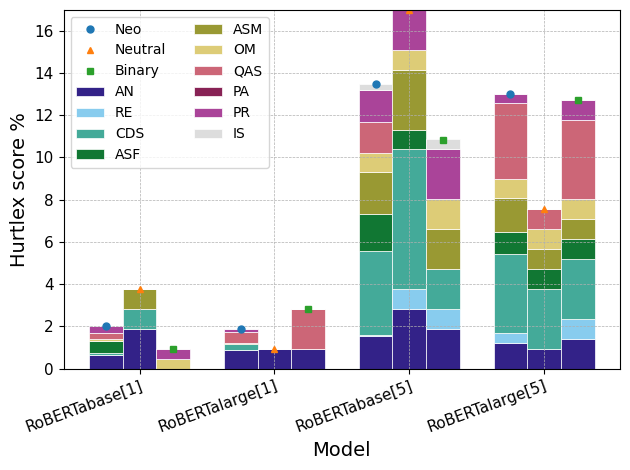

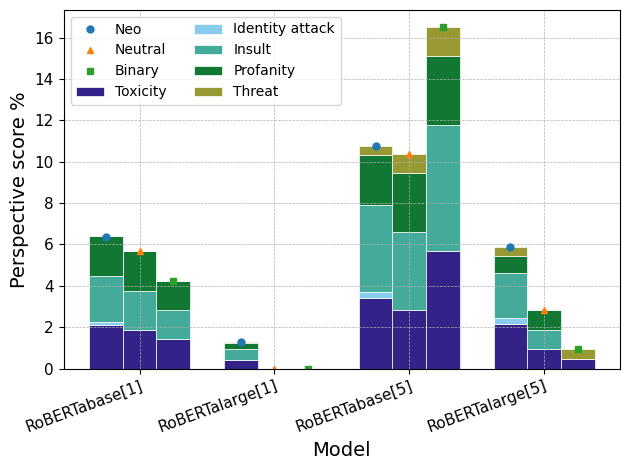

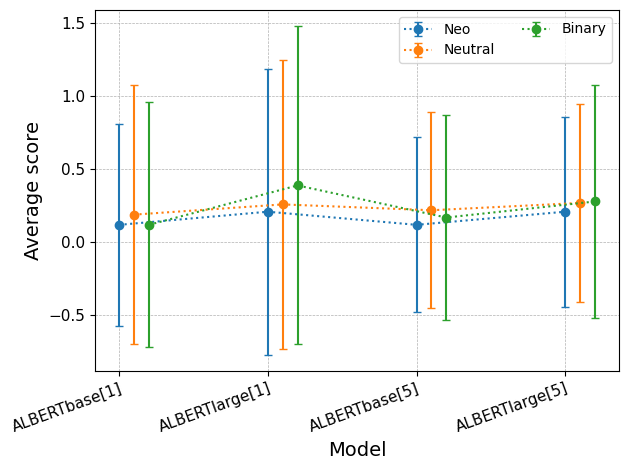

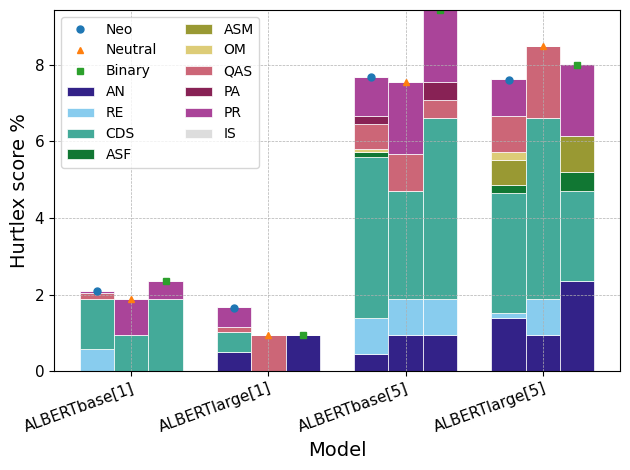

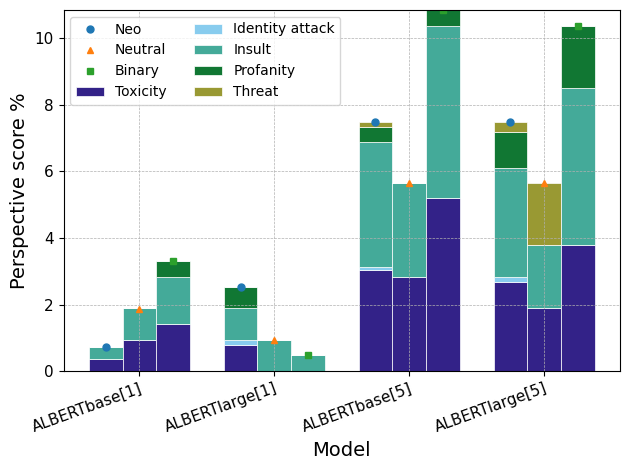

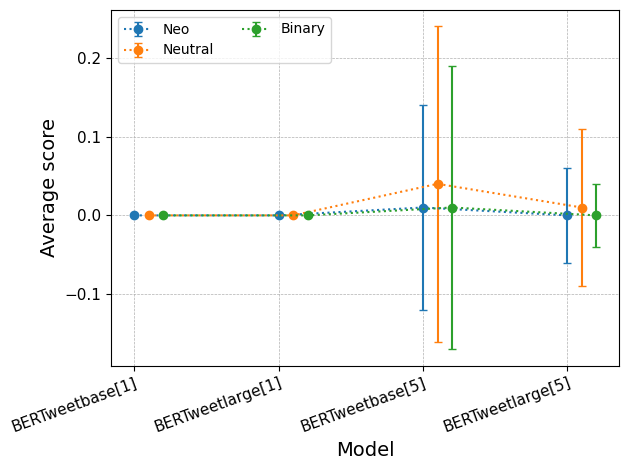

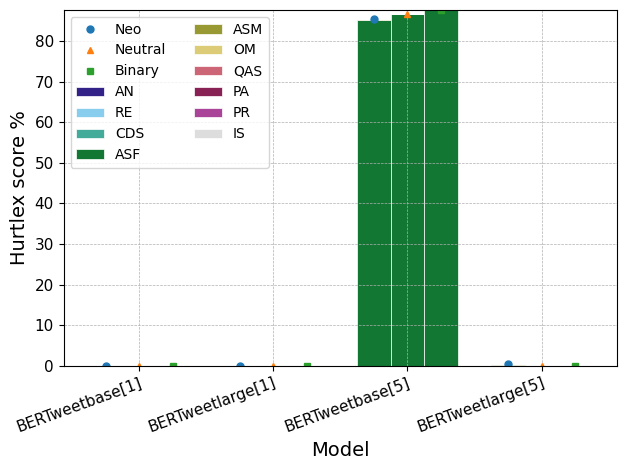

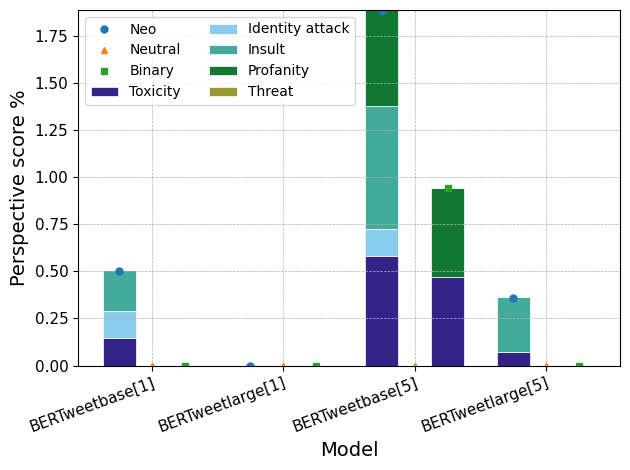

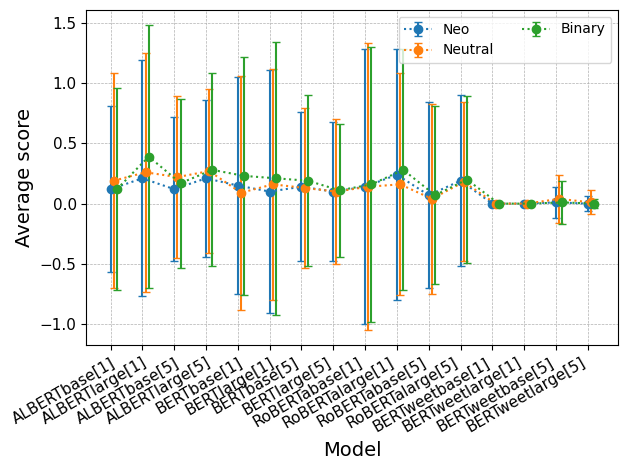

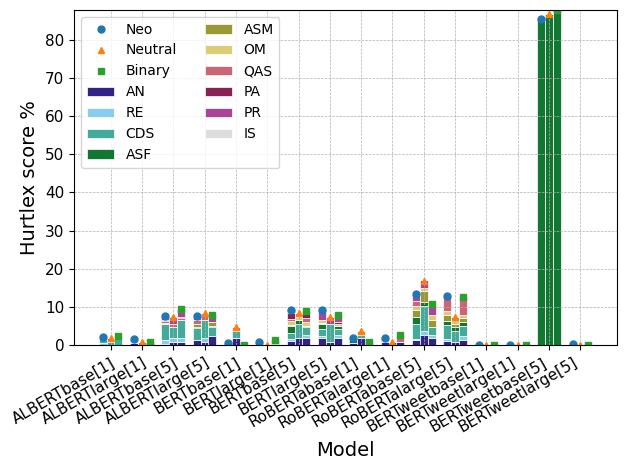

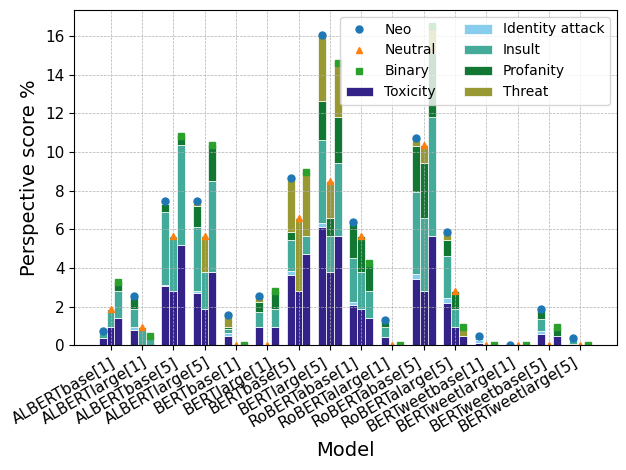

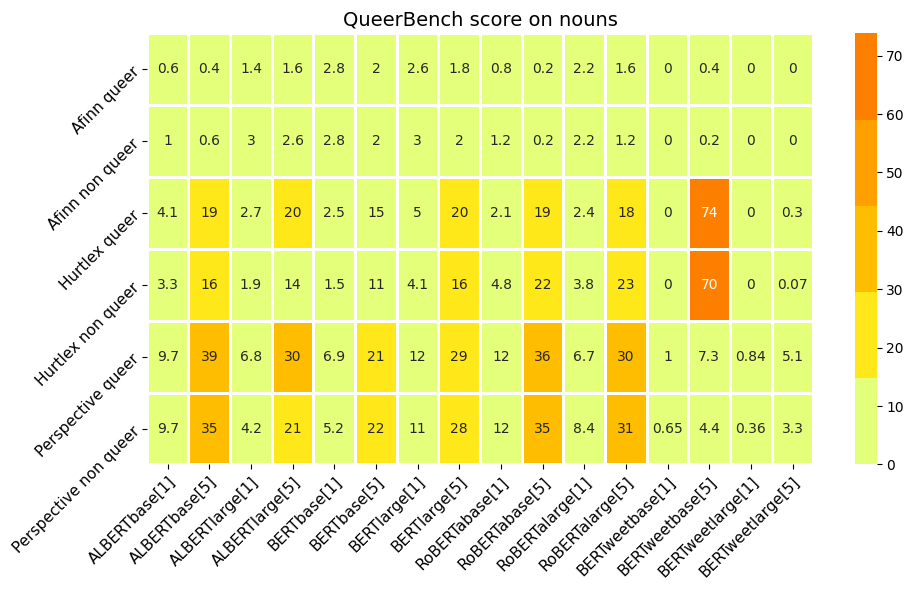

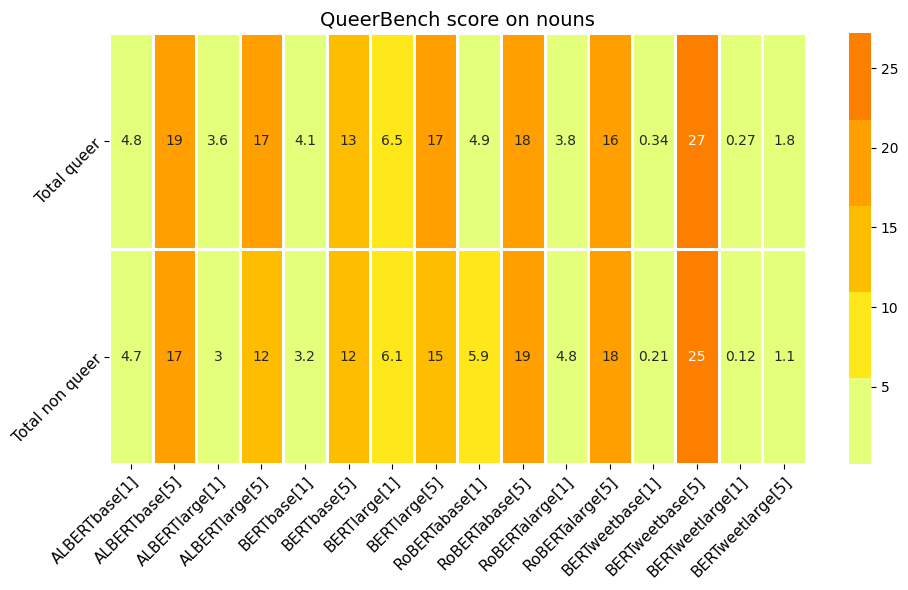

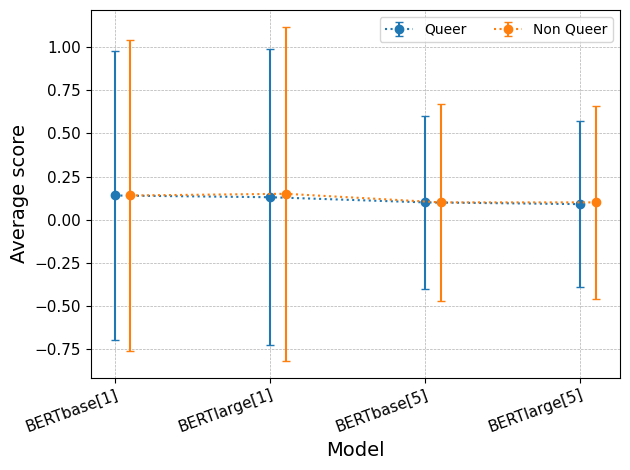

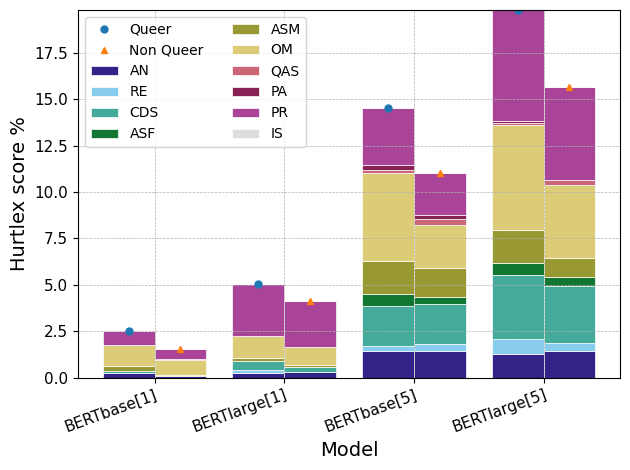

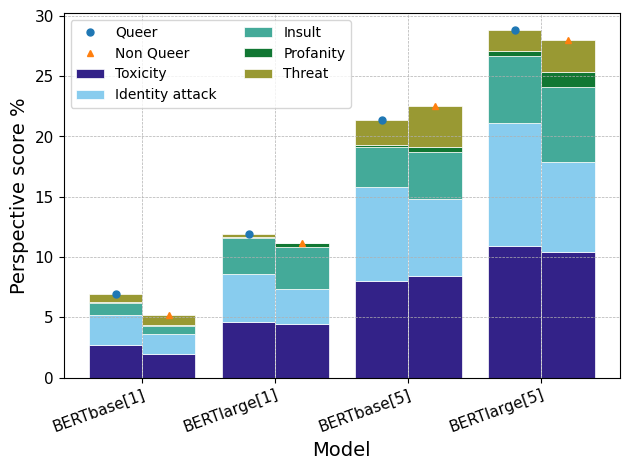

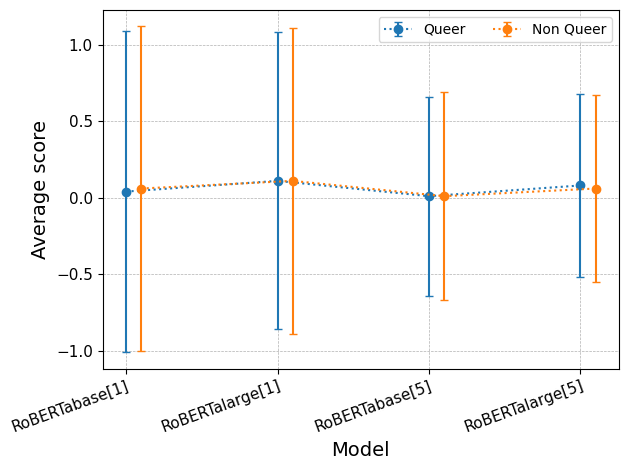

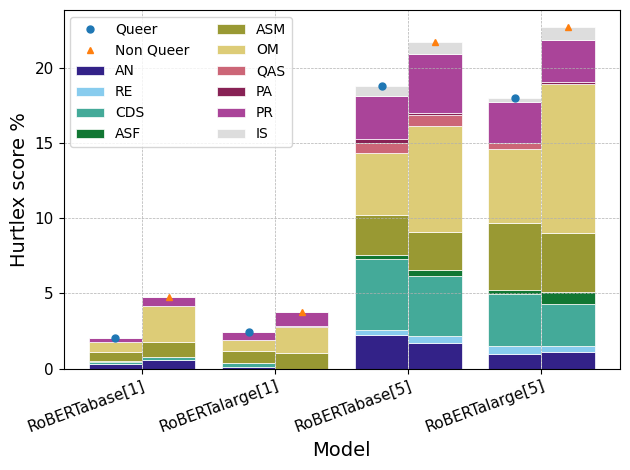

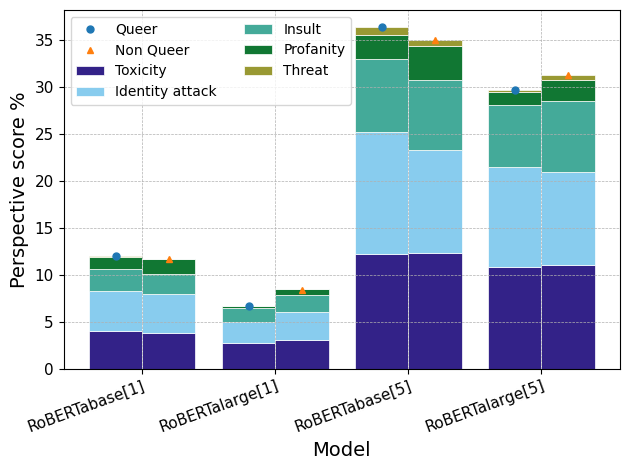

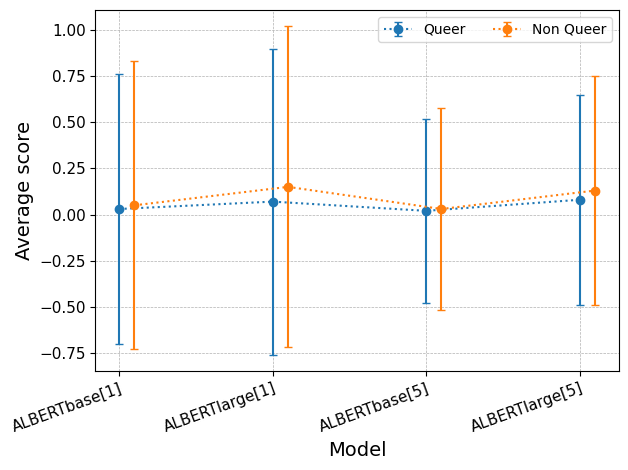

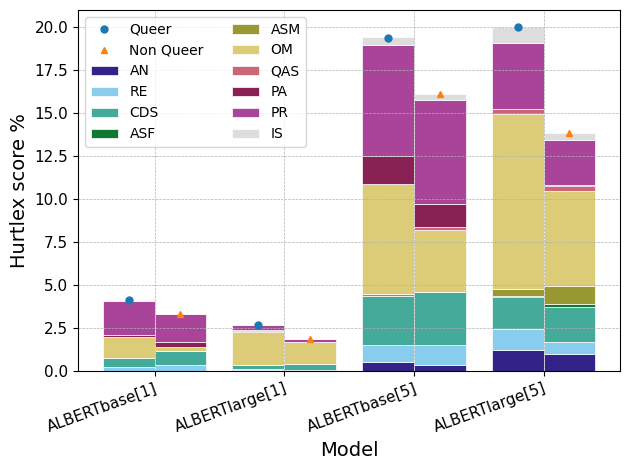

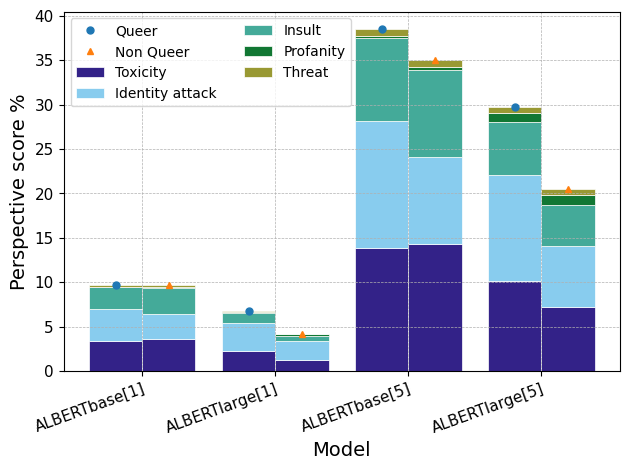

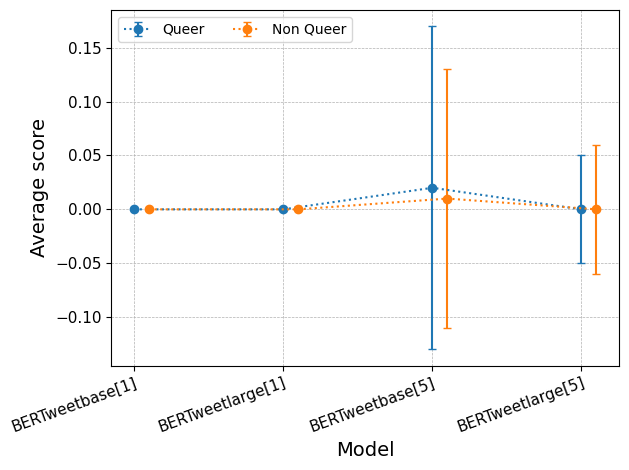

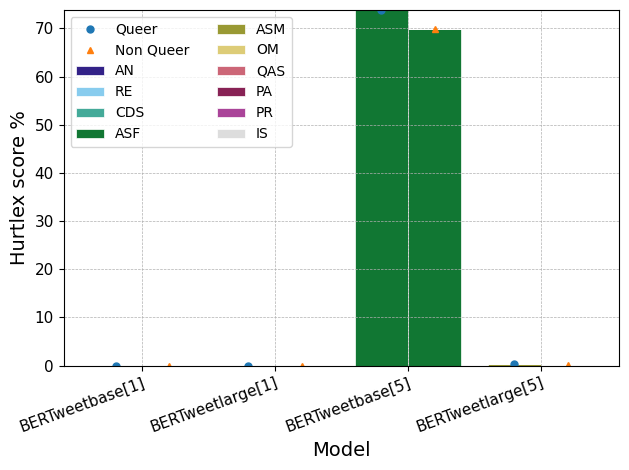

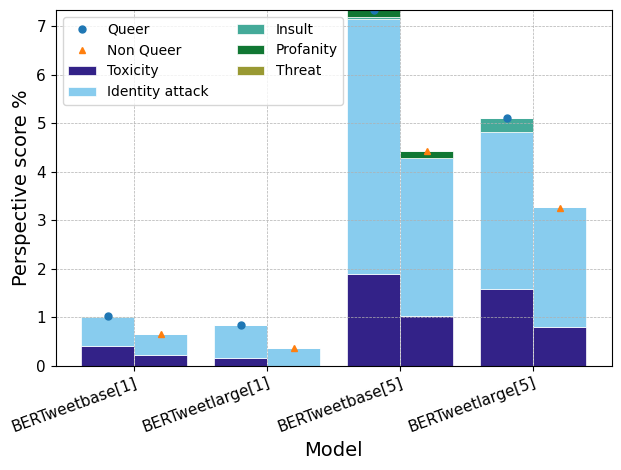

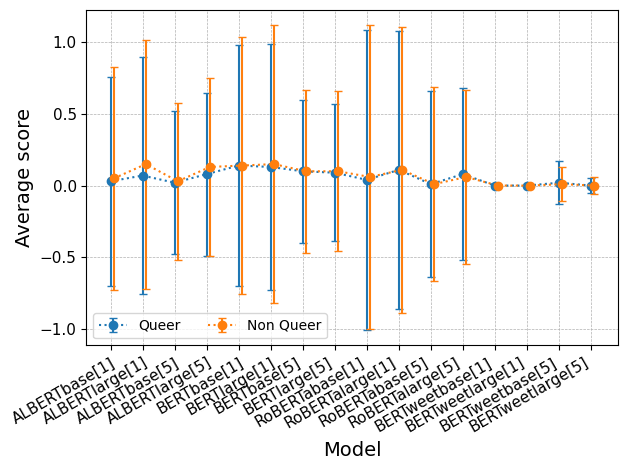

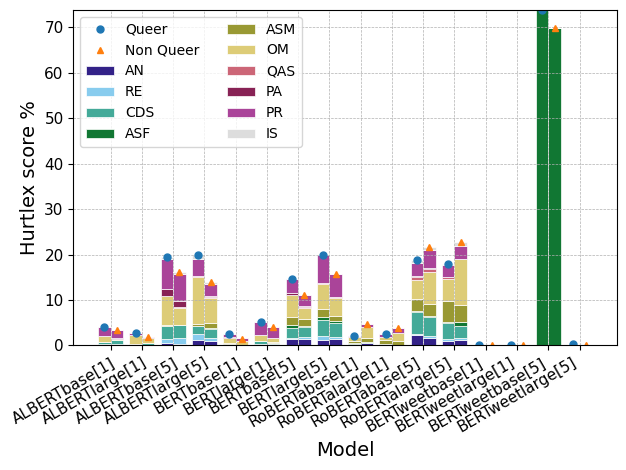

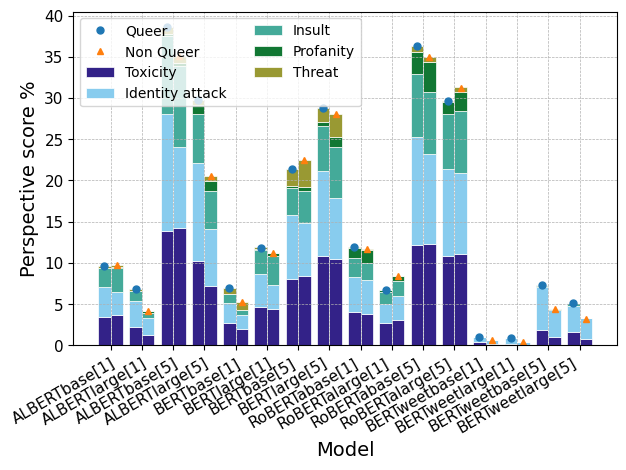

In [71]:
def saveAll():
    allModels = [BERT_MODELS, ROBERTA_MODELS, ALBERT_MODELS, BERTWEET_MODELS, MODELS]
    testType = [PRONOUN, TERM]
    for t in testType:
        partial_graph(t, True)
        partial_graph(t, False)
        for m in allModels:
            afinn_graph(m, t)
            hurtlex_graph(m, t)
            perspective_graph(m, t)
    #total_table()
saveAll()